<a href="https://colab.research.google.com/github/Rajeeb321123/Large-Language-model/blob/master/4_Memorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

# Preprocessing

In [ ]:
!python -m pip install --upgrade pip -q
!pip install transformers  -q -U
!pip install bitsandbytes  -q -U
!pip install peft  -q -U
!pip install accelerate  -q -U
!pip install flash  -q -U
!pip install  datasets -q -U
!pip install  scipy -q -U
!pip install  trl -q -U
!pip install  hf_transfer -q -U
!pip install  huggingface_hub -q -U
!pip install  wandb -q -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!transformers-cli env

2024-05-16 14:44:41.655662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 14:44:41.655722: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 14:44:41.788451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 14:44:43.995002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
2024-05-16 14:44:50.541134: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH en

In [ ]:
## Unsloth install

In [ ]:
# # # Empty VRAM
# del model

# # del trainer
# import gc
# gc.collect()
# gc.collect()

## Load Model

In [ ]:
# For gated models on HuggingFace
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
%env HF_HUB_ENABLE_HF_TRANSFER = True # for high speed downloading and uploading to hugging face hub

env: HF_HUB_ENABLE_HF_TRANSFER=True # for high speed downloading and uploading to hugging face hub


In [ ]:
cache_dir = '' # comment out if Google Drive is aset as cache_dir

# base model (Unsupervised Trial)
model_id = "openchat/openchat_3.5"

In [ ]:
## Load the model and Tokenizer of LoRA or DoRA
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

bnb_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16, # if newer gpu: bfloat16
)

In [ ]:
# config = AutoConfig.from_pretrained(model_id)
# cofig.max_position_embeddings = 4096 # (input + output) #model will only learn from max 4096 sequence of token

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    #config=config,

    quantization_config=bnb_config,

    #rope_scaling={"type":linear, "factor": 2.0}, # roPE scaling: https://www.hopsworks.ai/dictionary/rope-scaling and https://huggingface.co/docs/text-generation-inference/en/basic_tutorials/preparing_model

    #https://huggingface.co/docs/accelerate/v0.25.0/en/concept_guides/big_model_inference
    # device_map='auto', # It’s fully possible to create your own device map for the layers to use as well, specifying the GPU device to use (a number), "cpu", or "disk" and pass this in:
    device_map = {"": 0}, # above auto wasnot working

    # Here, the "trust_remote_code=True" means "download the model code from huggingface repo 'internlm/internlm-chat-7b'", along with the weight, and run it. If it's False, the library would use builtin model architectures hardcoded in huggingface/transformers and only download the weight.
    #trust_remote_code=False,

    torch_dtype=torch.float16, # if newer gpu: bfloat16

    # https://huggingface.co/docs/text-generation-inference/en/conceptual/flash_attention
    # attn_implementation="flash_attention_2", # Works with llama model

    cache_dir = cache_dir
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/623 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/179 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=False)

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
## Load the Model and Tokenizer for Unsloth

## Loading checks

In [ ]:
# Check there are no parameter overflowing onto cpu (meta)
# Making sure all of the parameter are in GPU not in CPU
for n, p in model.named_parameters():
  if p.device.type == "meta":
    print(f"{n} is on meta")

In [ ]:
print(model.config.max_position_embeddings)

#eos = end of sequence
# https://huggingface.co/docs/transformers/en/pad_truncation
# very important for pad and eos use: https://www.natebrake.com/blog/llm/end-of-sequence-explained
print(model.config.eos_token_id)

8192
32000


In [ ]:
## Prepare for LoRA fine-tuning
def print_trainable_parameters(model):
  """
  Print the number of trainable parameters in the model and lists whic
  """
  trainable_params = 0
  non_trainable_params = 0
  all_params = 0

  print("Trainable Parameters:")
  for name, param in model.named_parameters():
    # https://www.geeksforgeeks.org/python-pytorch-numel-method/
    # Total no of all parameters (trainable + non trainable)
    all_params += param.numel() #PyTorch torch.numel() method returns the total number of elements in the input tensor.

    # source: copilot: ask about param.requires_drad
    # When requires_grad is set to True, it indicates that the parameter participates in gradient computation during backpropagation (i.e., it’s trainable).
    #When requires_grad is set to False, the parameter is excluded from gradient updates during training (i.e., it’s frozen).
    if param.requires_grad:
      trainable_params += param.numel()
      print(f"  {name} ")
    else:
      non_trainable_params += param.numel()

  # This part is same as else portion above but just for printing we did it again
  print("\nNon_Trainable Parameters")
  for name, param in model.named_parameters():
    if not param.requires_grad:
      print(f" {name} ")


  print(
      f"\nSummary:\n Trainable params: {trainable_params}\n Non-Trainable params:{non_trainable_params}"
  )

## Standard LoRA or DoRA

In [ ]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32002, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Important documentaion for large model faster training.

https://huggingface.co/docs/transformers/v4.18.0/en/performance

In [ ]:
from peft import prepare_model_for_kbit_training

# look at gradient checkpointing and gradient accumulation on https://huggingface.co/docs/transformers/v4.18.0/en/performance
model.gradient_checkpointing_enable() # to save some memory in VRAM in turn for little slow training

model = prepare_model_for_kbit_training(model) # for quantization, must be uncommented.

from peft import LoraConfig, get_peft_model

# Understaing Lora parameters: https://medium.com/@drishtisharma96505/comparative-analysis-of-lora-parameters-on-llama-2-with-flash-attention-574b913295d4
peft_config = LoraConfig( #matching the Llama recipe
                         r = 8,
                          lora_alpha = 32,
                          target_modules = [
                              "q_proj",
                              "k_proj",
                              "v_proj",
                              "o_proj",
                              # "self_attn.rotary_emb.inv_freq",

                              ## comment out 3 below for mixtril
                              "gate_proj",
                              "up_proj",
                              "down_proj",

                              # "lora_magnitude_vector" # required for DoRA,
                              # "input_layernorm.weight",
                              # "post_attention_layernorm.weight",
                              # "model.norm.weight",
                              # "lm_head.weight",


                              # "dense_h_to_4h",  #for falcon
                              # "dense_4h_to_h",  #for falcon
                              # "query_key_value",  #for falcon
                              # "dense" #for falcon
                          ],
                          lora_dropout = 0.1,
                          bias = "none",
                          task_type="CAUSAL_LM"
                          )

model = get_peft_model(model, peft_config) #move to a peft model

In [ ]:
# print_trainable_parameters(model)

In [ ]:
## Unsloth LoRA

## Set up Tokenizer and Padding

In [ ]:
print(tokenizer)
print(tokenizer.vocab_size)

LlamaTokenizerFast(name_or_path='openchat/openchat_3.5', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '<|end_of_turn|>', 'unk_token': '<unk>', 'additional_special_tokens': ['<|end_of_turn|>', '<|pad_0|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<|end_of_turn|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<|pad_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
32000


In [ ]:
print(tokenizer.bos_token) #check begining of sequence
print(tokenizer.eos_token) # end of sequence

<s>
<|end_of_turn|>


In [ ]:
# # Optionally set the chat template manually.
# tokenizer.chat_template = "{ if not add_generation_prompt is defined %}"

# Test the chat template
messages = [
    {'role': 'user', 'content': "write a quick sort algorithm in python"},
    {'role': 'assistant', 'content': "here your are"},
    {'role': 'user', 'content':"great."}
]

# When you set tokenize=False in the tokenizer.apply_chat_template() function, it means that the resulting chat template output will not be tokenized into individual tokens. Instead, it remains as a single string without any tokenization. This can be useful when you want to keep the entire chat history intact for further processing or analysis. 😊
inputs = tokenizer.apply_chat_template(messages, tokenize = False)
print(inputs)

<s>GPT4 Correct User: write a quick sort algorithm in python<|end_of_turn|>GPT4 Correct Assistant: here your are<|end_of_turn|>GPT4 Correct User: great.<|end_of_turn|>


In [ ]:
# very important for pad and eos use: https://www.natebrake.com/blog/llm/end-of-sequence-explained
# Choosing pad_token for tokenizer

## Option A - set the pad token to <pad>, if not <|pad|>, if not <unk> if
if '<pad>' in tokenizer.get_vocab():
  print('<pad> token is in the tokenizer. Using <pad> for pad')
  #set the pad token
  tokenizer.pad_token = '<pad>'
elif '<|pad|>' in tokenizer.get_vocab():
  print('<|pad|> token is in the tokenizer. Using <|pad|> for pad')
  #set the pad token
  tokenizer.pad_token = '<|pad|>'
elif '<unk>' in tokenizer.get_vocab():
  print('<unk> token is in the tokenizer. Using unk for pad')
  # Set the pad token
  tokenizer.pad_token = '<unk>'
else: # choosing eos_token as pad_token may be risky.
  print(f'Using EOS token, {tokenizer.eos_token}, for padding.')
  tokenizer.pad_token = tokenizer.eos_token


# ## OPTION B - create pad token
# # Check if the pad token is already in the tokenizer vocabulary
# if '<pad>' not in tokenizer.get_vocab():
#   print('pad token not in the tokenizer, adding a <pad> token')

#   #Add the pad token
#   tokenizer.add_tokens(['<pad>'])
#   # set the pad token
#   tokenizer.pad_token = '<pad>'
#   # Resize token embeddings
#   model.resize_token_embeddings(tokenizer.vocab_size)

<unk> token is in the tokenizer. Using unk for pad


In [ ]:
# Update pad token id in model and it's config
model.pad_token_id = tokenizer.pad_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# Check if they are equal
assert model.pad_token_id == tokenizer.pad_token_id

# Print the pad token ids
print('Tokenizer pad token ID:', tokenizer.pad_token_id)
print('Model pad token ID:', model.pad_token_id)
print('Model config pad token ID:', model.config.pad_token_id)
print('Number of tokens now in tokenizer:', tokenizer.vocab_size)

Tokenizer pad token ID: 0
Model pad token ID: 0
Model config pad token ID: 0
Number of tokens now in tokenizer: 32000


In [ ]:
print("Special tokens map:", tokenizer.special_tokens_map)
print( "All special tokens:", tokenizer.all_special_tokens)

Special tokens map: {'bos_token': '<s>', 'eos_token': '<|end_of_turn|>', 'unk_token': '<unk>', 'pad_token': '<unk>', 'additional_special_tokens': ['<|end_of_turn|>', '<|pad_0|>']}
All special tokens: ['<s>', '<|end_of_turn|>', '<unk>', '<|pad_0|>']


In [ ]:
tokenizer.padding_side = 'right'

In [ ]:
# # Uncomment to switch to left padding, not recommended for unsloth
# tokenizer.padding_side = 'left # left padding is ususally not good idea for most model, but some use cases it may be useful

In [ ]:
print(tokenizer)

LlamaTokenizerFast(name_or_path='openchat/openchat_3.5', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '<|end_of_turn|>', 'unk_token': '<unk>', 'pad_token': '<unk>', 'additional_special_tokens': ['<|end_of_turn|>', '<|pad_0|>']}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<|end_of_turn|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<|pad_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


## Set embed and norms layers to trainable (recommended only for chat fine tuning if your changing the template or changing the context length)

In [ ]:
# TODO

## Set up Evaluation

- optional

In [ ]:
from transformers import TextStreamer
from peft import PeftModel
import torch
import gc  # import Python's garbage collection module

# Define a stream
def Stream(user_prompt, model_type, tokenizer, checkpoint=''):

  if model_type == 'base':
    eval_model = model
  elif model_type == 'fine-tuned':
    eval_model = PeftModel.from_pretrained(model, checkpoint)
    eval_model = eval_model.to("cuda") # compute in GPU

    for n, p in eval_model.named_parameters():
      if p.device.type == "cpu":
        print(f"{n} is on CPU!")
  else:
    print("You must set the model_type to base or fine-tuned")

  # print (f'Proceeding to inference with peft adapters from {checkpoint}')

  # Source: chatgpt: model.config.use_cache = True
  # The use_cache option allows the model to cache intermediate hidden states and attention weights as it generates tokens.
  # This cache helps speed up subsequent token generation by reusing previously computed information.
  # If you’re generating long sequences or performing autoregressive tasks (where each token depends on previous tokens), enabling cache can significantly improve decoding speed.
  eval_model.config.use_cache = True

  messages = [
      # strip() returns new string with extra(unwanted) white space removed
      {'role': 'user', 'content': f"{user_prompt.strip()}",}
  ]

  # add generation prompt must be true for giving ai where to start it's geneartion from in chat prompt eg: this will add at the end: <|im_start|>assistant
  inputs = tokenizer.apply_chat_template(messages, tokenize = False, add_generation_prompt=True)

  # "pt" means pytorch tensors When you set return_tensors="pt", the tokenizer or model returns the tokenized input as PyTorch tensors.
  #These tensors can be directly used for model inference or fine-tuning.
  inputs = tokenizer([inputs], return_tensors="pt", add_special_tokens=False)

  # there will be token_type_ids in the end of prompt like Token Type IDs: [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
  # these are useful for many places but not here.
  if "token_type_ids" in inputs: # we don't token_type_ids here
    del inputs["token_type_ids"]

  streamer = TextStreamer(tokenizer)

  print(f'eval_model is on:',{next(eval_model.parameters()).device}) # CPu or CUDA
  print(f'input_ids are on: {inputs["input_ids"].device}')

  # parameter of .generate: https://huggingface.co/docs/transformers/en/main_classes/text_generation
  _ = eval_model.generate(**inputs, streamer=streamer, max_new_tokens=10, use_cache=True)

  # Clear GPU cache and run garbage collection
  torch.cuda.empty_cache() # Clear GPU cache
  gc.collect() # Run garbage collection

def evaluation(model_type, tokenizer, checkpoint=''):
  questions = [
    "In the context of Touch Rugby Internation Rules 2020, what does the dead ball line marks?",
    "How many players are on the field on each team in touch rugby?",
    "In touch rugby, does a forward pass result in a roll ball or a Penalty",
    "In touch rughby, how long is half time?"
    "In touch rugby, how does the game commence?"
    "In touch rugby, how many points is a try worth?"
    ""
  ]

  answers = [
      " The Dead ball line marks the end boundaries of the field of play",
      "6 players",
      "Penalty",
      "5 minutes",
      "The game begins with a tap on the halfway line"
      "1 point"
  ]

  for question, answer in zip(questions, answers):
    Stream(question, model_type, tokenizer, checkpoint)
    print("Correct Answer:", answer)
    print('\n\n')

In [ ]:
print(model.config)

MistralConfig {
  "_name_or_path": "openchat/openchat_3.5",
  "architectures": [
    "MistralForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 32000,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 8192,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "pad_token_id": 0,
  "quantization_config": {
    "_load_in_4bit": true,
    "_load_in_8bit": false,
    "bnb_4bit_compute_dtype": "float16",
    "bnb_4bit_quant_storage": "uint8",
    "bnb_4bit_quant_type": "nf4",
    "bnb_4bit_use_double_quant": true,
    "llm_int8_enable_fp32_cpu_offload": false,
    "llm_int8_has_fp16_weight": false,
    "llm_int8_skip_modules": null,
    "llm_int8_threshold": 6.0,
    "load_in_4bit": true,
    "load_in_8bit": false,
    "quant_method": "bitsandbytes"
  },
  "rms_norm_eps": 1e-05,
  "rope_theta": 10000.0,
  "sliding_w

In [ ]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": 32000,
  "max_length": 8192,
  "pad_token_id": 0,
  "temperature": 0.5
}



In [ ]:
# checking the base model which hasnot been fine tunned
evaluation("base", tokenizer)

eval_model is on: {device(type='cuda', index=0)}
input_ids are on: cpu


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


<s> GPT4 Correct User: In the context of Touch Rugby Internation Rules 2020, what does the dead ball line marks?<|end_of_turn|> GPT4 Correct 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1510: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Assistant: In Touch Rugby International Rules 202
Correct Answer:  The Dead ball line marks the end boundaries of the field of play



eval_model is on: {device(type='cuda', index=0)}
input_ids are on: cpu
<s> GPT4 Correct User: How many players are on the field on each team in touch rugby?<|end_of_turn|> GPT4 Correct 

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


Assistant: In touch rugby, each team has 13
Correct Answer: 6 players



eval_model is on: {device(type='cuda', index=0)}
input_ids are on: cpu
<s> GPT4 Correct User: In touch rugby, does a forward pass result in a roll ball or a Penalty<|end_of_turn|> GPT4 Correct Assistant: In touch rugby, a forward pass results in a
Correct Answer: Penalty



eval_model is on: {device(type='cuda', index=0)}
input_ids are on: cpu
<s> GPT4 Correct User: In touch rughby, how long is half time?In touch rugby, how does the game commence?In touch rugby, how many points is a try worth?<|end_of_turn|> GPT4 Correct Assistant: In touch rugby, half time is typically 5
Correct Answer: 5 minutes





## Load the Dataset

In [ ]:
from datasets import load_dataset

dataset = 'Trelis/touch-rugby-rules-memorisation'

data = load_dataset(dataset)

Generating train split:   0%|          | 0/303 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60 [00:00<?, ? examples/s]

In [ ]:
# Print frist row of 'train and 'test'
print("First row of train:", data['train'][1])
print("First row of test:", data['test'][0])

First row of train: {'messages': '{"messages": [{"role": "user", "content": "According to the copyright notice, who holds the rights to the Touch Football Rules?"}, {"role": "assistant", "content": "Touch Football Australia holds the rights to the Touch Football Rules as they are protected by copyright laws."}, {"role": "user", "content": "What should players, coaches, and referees do if there are any adaptations or alterations to the rules for local competitions?"}, {"role": "assistant", "content": "Players, coaches, and referees should refer to relevant competition guidelines where any adaptations or alterations to the rules for local competitions are clearly articulated."}, {"role": "user", "content": "What is the purpose of Appendix 1 in the document?"}, {"role": "assistant", "content": "Appendix 1 provides information about the Field of Play in the Touch Football rules."}, {"role": "user", "content": "What is the term used to describe the period of time after an Infringement in wh

In [ ]:
# Extract text from the first row of 'test' in data
text = data['train'][0]['messages']

# Tokenize the text
tokens = tokenizer.encode(text, add_special_tokens = True)

# Decode back to text
decoded_text = tokenizer.decode(tokens)

# Print the tokens and decode text
print("Token IDs:", tokens)
print("Decode Text:", decoded_text)

Token IDs: [1, 9830, 16167, 1264, 733, 6799, 9606, 1264, 345, 1838, 548, 345, 3789, 1264, 345, 3195, 12065, 302, 272, 25086, 13474, 5879, 403, 7567, 486, 25086, 13474, 6664, 438, 272, 22520, 302, 5440, 25086, 5465, 23717, 297, 4527, 28705, 28750, 28734, 28740, 28774, 1110, 881, 9830, 9606, 1264, 345, 489, 11143, 548, 345, 3789, 1264, 345, 1014, 320, 3120, 28705, 28783, 362, 20356, 6879, 288, 24759, 654, 7567, 486, 25086, 13474, 6664, 438, 272, 22520, 302, 5440, 25086, 5465, 23717, 297, 4527, 28705, 28750, 28734, 28740, 28774, 611, 881, 9830, 9606, 1264, 345, 1838, 548, 345, 3789, 1264, 345, 11447, 15813, 298, 8799, 272, 320, 3120, 28705, 28783, 362, 20356, 6879, 288, 24759, 390, 272, 28705, 28782, 362, 20356, 12630, 6879, 288, 24759, 17861, 578, 1110, 881, 9830, 9606, 1264, 345, 489, 11143, 548, 345, 3789, 1264, 345, 1014, 12630, 9217, 15813, 298, 8799, 272, 320, 3120, 28705, 28783, 362, 20356, 6879, 288, 24759, 390, 272, 28705, 28782, 362, 20356, 12630, 6879, 288, 24759, 298, 347, 130

# Train

## Set up and run Training (with saving of data logs to Drive)

using TRL trainer is recommended.

### TRL Trainer

In [ ]:
model_name = model_id.split("/")[-1]
dataset_name = dataset.split("/")[-1]

#parameters
epochs = 1 # 1 epochs is good enough here
context_length = 512 # most of the time Q and A arenot longer than 512

# backpropagation params
grad_accum = 1 # virtually increase the batch size. Maynot affect VRam but increase Training time
batch_size = 1 # just granuale update # smooth and less update for help in memorization

fine_tune_tag = 'touch_rugby-rules'
save_dir = f'./results/{model_name}_{dataset_name}_{epochs}_epochs_{context_length}_length_{grad_accum}_grad_accum_{batch_size}_batch_size_{fine_tune_tag}'
print(save_dir)

./results/openchat_3.5_touch-rugby-rules-memorisation_1_epochs_512_length_1_grad_accum_1_batch_size_touch_rugby-rules


In [ ]:
# #Custom callback for just logging
# import transformers
# import os

# # custom callback to log metrics
# class LoggingCallback(transformers.TrainerCallback):
#   def _init_(self, log_file_path):
#     self.log_file_path = log_file_path
#     self.save_dir = save_dir

#   def on_log(self, args, state, control, model = None, **kwargs):
#     with open(self.log_file_path, 'a') as f:
#       if 'loss' in loss:
#         f.write(f"Step: {state.global_step}, Training Loss: {logs["loss"]}")
#       if 'eval_loss' in loss:
#         f.write(f"Step: {state.global_step}, Eval Loss: {logs['eval_loss']}")

#       f.flush() # Force flush the buffered data to file

#     # Check if the current step is a checkpoint step
#     if state.global_step % int(args.save_steps) == 0:
#       # Check if the last checkpoint path exists
#       if state.best_model_checkpoint:
#         checkpoint_dir = state.best_model_checkpoint
#       else:
#         # if not, construct the checkpoint directory path manually
#         checkpoint_dir = os.path.join(args.output_dir, f"checkpoint")

#       #Ensure the checkpoint directory exist
#       os.makedirs(checkpoint_dir, exist_ok=True)

#       # Save trainable params in the checkpoint directory
#       current_trainable_params = {n: p for n, p in model.named_parameters()}
#       current_trainable_params_state_dict = {n:p.data for n, p in current_trainable_params}

#       file_path = os.path.join(checkpoint_dir, "trainable_params.bin")
#       torch.save(current_trainable_params_state_dict, file_path)

# # log file path
# log_file_path = os.path.join(cache_dir, "training_logs.txt")

# # Creating an instance of custom callback class
# logging_callback = LoggingCallback(log_file_path)

SyntaxError: f-string: unmatched '[' (<ipython-input-52-4df9bbb9223f>, line 14)

In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from transformers import Trainer
from transformers import TrainingArguments
from trl import SFTTrainer

trainer = SFTTrainer(
    # peft_config = peft_config # not needed where as look at above we have already put peft config directly into model but we comment it out
    dataset_text_field = "messages", # key fied = "messages" in dataset in key , value pair
    max_seq_length = context_length, # max length of query
    tokenizer = tokenizer,
    model=model.to("cuda"),
    train_dataset = data["train"],
    eval_dataset = data["test"],

    # about all the parameters: https://huggingface.co/docs/transformers/en/main_classes/trainer
    args = TrainingArguments(
        max_steps =1, # comment this out after first time you run.
        save_steps = 50, ### make sure to check this value is good for our data, The save_steps parameter specifies the number of training steps between consecutive model checkpoints.
        num_train_epochs = epochs,
        output_dir = save_dir,
        evaluation_strategy = "steps", # evaluation is done in every eval_steps
        do_eval= True,
        eval_steps = 0.2,
        per_device_eval_batch_size = batch_size,
        per_device_train_batch_size = batch_size,
        gradient_accumulation_steps = grad_accum,
        log_level ="debug",
        optim = "paged_adamw_32bit", # if quantization
        fp16 = True, # for low end non_ampere Gpu
        #bf16 = True, # for only ampere GPU
        max_grad_norm = 0.3,#The max_grad_norm value represents the maximum allowed norm (magnitude) of the gradients during backpropagation.. By setting a maximum norm, you prevent gradients from becoming too large, which can lead to unstable training or divergence.

        # from chatgpt
        # here cosine will be game changer as it decrease validataion loss and against overfitting
        lr_scheduler_type = "cosine", # follow cosine shaped curve. cosine shape curve make sure lr decrease ove steps.
        hub_private_repo = False,

        # from chatgpt
        # Warmup is an initial phase where the learning rate gradually increases from a very small value to its regular value. (0 to lr)
        # It helps stabilize training and allows the model to explore the loss landscape more effectively.
        # If you set warmup_ratio = 0.03 and T_max = 1000, the warmup phase will last for the first 30 steps (3% of the total).
        warmup_ratio = 0.03,
        # optim = "adamw_torch", # commented for LoRA+, we are using lora so needed
        learning_rate= 1e-4, # comment for LoRA +
        report_to="tensorboard",
    ),
    # ,callbacks = [logging_callback], # if custom callback created
    # optimizers = (optimizer, None) # for only LoRA +
    # neftune_noise_alpha = 5 # Add in noise embeddings to improve performance
)

PyTorch: setting up devices


Map:   0%|          | 0/303 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs
Using auto half precision backend


In [ ]:
model.config.use_cache = False # for silencing warnings only
trainer.train()

Currently training with a batch size of: 1
***** Running training *****
  Num examples = 303
  Num Epochs = 1
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 1
  Number of trainable parameters = 20,971,520
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
1,No log,1.489708


***** Running Evaluation *****
  Num examples = 60
  Batch size = 1


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1, training_loss=1.4443329572677612, metrics={'train_runtime': 60.8159, 'train_samples_per_second': 0.016, 'train_steps_per_second': 0.016, 'total_flos': 13478799237120.0, 'train_loss': 1.4443329572677612, 'epoch': 0.0033003300330033004})

# Plotting

In [ ]:
pip install matplotlib

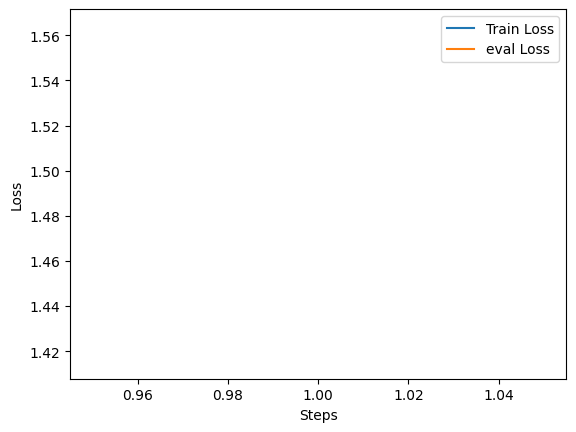

In [ ]:
import matplotlib.pyplot as plt

# Initialize list to hold training and evaluation losses and steps
train_losses = []
eval_losses = []
train_steps = []
eval_steps = []

#Populate the list from log history
#import pandas as pd
# pd.DataFrame(trainer.state.log_history)
for entry in trainer.state.log_history:
  if 'loss' in entry:
    train_losses.append(entry['loss'])
    train_steps.append(entry['step'])
  if 'eval_loss' in entry:
    eval_losses.append(entry['eval_loss'])
    eval_steps.append(entry['step'])

# plot the losses
plt.plot(train_steps, train_losses, label = 'Train Loss')
plt.plot(eval_steps, eval_losses, label = 'eval Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate After Training

In [ ]:
# # Can set to true for faster inference
# model.config.use_cache = True

In [ ]:
evaluation("base", tokenizer) # use this if trained using adapter

eval_model is on: {device(type='cuda', index=0)}
input_ids are on: cpu
<s> GPT4 Correct User: In the context of Touch Rugby Internation Rules 2020, what does the dead ball line marks?<|end_of_turn|> GPT4 Correct 

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1510: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


Assistant: In Touch Rugby International Rules 202
Correct Answer:  The Dead ball line marks the end boundaries of the field of play



eval_model is on: {device(type='cuda', index=0)}
input_ids are on: cpu
<s> GPT4 Correct User: How many players are on the field on each team in touch rugby?<|end_of_turn|> GPT4 Correct Assistant: In touch rugby, each team has 13
Correct Answer: 6 players



eval_model is on: {device(type='cuda', index=0)}
input_ids are on: cpu
<s> GPT4 Correct User: In touch rugby, does a forward pass result in a roll ball or a Penalty<|end_of_turn|> GPT4 Correct Assistant: In touch rugby, a forward pass results in a
Correct Answer: Penalty



eval_model is on: {device(type='cuda', index=0)}
input_ids are on: cpu
<s> GPT4 Correct User: In touch rughby, how long is half time?In touch rugby, how does the game commence?In touch rugby, how many points is a try worth?<|end_of_turn|> GPT4 Correct Assistant: In touch rugby, half time is typically 5
Correct Answer: 5 minutes


